# Images classification with AutoML for Images (Azure ML)

The code outlines a Python-based setup for using an ONNX local model for edge inferencing.

## 🖼️ ONNX for Computer Vision Models
ONNX (Open Neural Network Exchange) is an open-source format for representing machine learning models. Think of it as a universal language 🌐 that allows you to train a model in one framework and deploy it in another.

## 🎯 Why ONNX Matters for Computer Vision
When you build a computer vision model (like an image classifier, object detector, or segmentation model), you typically train it using frameworks like PyTorch, TensorFlow, or scikit-learn. But when it comes to deployment, you might want to:
- 📱 Run your model on different platforms (mobile, web, edge devices, cloud)
- ⚡ Use optimized inference engines for faster predictions
- 🔄 Switch frameworks without retraining from scratch
- 🤝 Standardize your ML pipeline across teams

# ✨ Key Benefits
- 🔗 Interoperability: Move models between frameworks seamlessly
- 🚀 Performance: ONNX Runtime includes optimizations like graph optimization, quantization, and hardware acceleration
- 🎛️ Flexibility: Deploy the same model across CPU, GPU, or specialized AI accelerators without modification

In [1]:
import datetime
import glob
import json
import logging
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime
import time
import torch
import sys
import warnings

from azureml.core import Experiment, Workspace
from azureml.train.automl.run import AutoMLRun
from dotenv import load_dotenv
from PIL import Image
from torchvision import transforms

In [2]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 20-Oct-2025 07:53:38


In [3]:
print("Python version =", sys.version)

Python version = 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


## 1. Helper

In [4]:
def _make_3d_tensor(x) -> torch.Tensor:
    """This function is for images that have less channels.

    :param x: input tensor
    :type x: torch.Tensor
    :return: return a tensor with the correct number of channels
    :rtype: torch.Tensor
    """
    return x if x.shape[0] == 3 else x.expand((3, x.shape[1], x.shape[2]))

In [5]:
def preprocess(image, resize_size, crop_size_onnx):
    """
    Preprocesses an input image for ONNX model inference.

    This function applies a series of transformations to the input image:
    - Resizes the image to the specified dimensions.
    - Crops the center of the image to match the ONNX model's expected input size.
    - Converts the image to a PyTorch tensor.
    - Ensures the tensor has 3 dimensions (channels, height, width).
    - Normalizes the image using ImageNet mean and standard deviation.
    - Converts the tensor to a NumPy array and adds a batch dimension.

    Args:
        image (PIL.Image): The input image to preprocess.
        resize_size (tuple): The target size for resizing (height, width).
        crop_size_onnx (int): The size for center cropping.

    Returns:
        np.ndarray: A preprocessed image ready for ONNX model input with shape (1, 3, crop_size_onnx, crop_size_onnx).
    """
    transform = transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size_onnx),
        transforms.ToTensor(),
        transforms.Lambda(_make_3d_tensor),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    img_data = transform(image)
    img_data = img_data.numpy()
    img_data = np.expand_dims(img_data, axis=0)
    
    return img_data

In [6]:
def get_predictions_from_ONNX(onnx_session, img_data):
    """Perform predictions with ONNX runtime
    
    :param onnx_session: onnx model session
    :type onnx_session: class InferenceSession
    :param img_data: pre-processed numpy image
    :type img_data: ndarray with shape 1xCxHxW
    :return: scores with shapes
            (1, No. of classes in training dataset) 
    :rtype: numpy array
    """

    sess_input = onnx_session.get_inputs()
    sess_output = onnx_session.get_outputs()
    print(f"No. of inputs : {len(sess_input)}, No. of outputs : {len(sess_output)}")    
    # predict with ONNX Runtime
    output_names = [ output.name for output in sess_output]
    scores = onnx_session.run(output_names=output_names,\
                                               input_feed={sess_input[0].name: img_data})
    
    return scores[0]

## 2. Azure ML workspace

In [7]:
load_dotenv("azure.env")

True

In [8]:
try:
    ws = Workspace(subscription_id = os.environ.get("subscription_id"), 
                   resource_group = os.environ.get("resource_group"), 
                   workspace_name = os.environ.get("workspace"))
    print("✅ Done")

except:
    print("❌ [Error] Workspace not found!")

✅ Done


## 3. Azure ML Experiment

In [9]:
experiment_name = "metal-defect-classautomlimages"

experiment = Experiment(ws, name=experiment_name)

In [10]:
# Suppress warnings at logging level
logging.getLogger().setLevel(logging.ERROR)

# Or suppress Python warnings
warnings.filterwarnings('ignore', message='Received unrecognized parameter')

In [11]:
run_id = 'yellow_board_9z7f40h9md' # Specify the run ID

best_child_run = AutoMLRun(experiment=experiment, run_id=run_id).get_best_child()

## 4. Downloading the labels & ONNX files from your AutoML for Images Azure ML job

In [12]:
ONNX_DIR = "onnx"

In [13]:
# Downloading the labels & onnx file
labels_file = os.path.join(ONNX_DIR, "labels.json")
best_child_run.download_file(name='train_artifacts/labels.json', output_file_path=labels_file)

onnx_model_path = os.path.join(ONNX_DIR, "model.onnx")
best_child_run.download_file(name='train_artifacts/model.onnx', output_file_path=onnx_model_path)

In [14]:
!ls $ONNX_DIR -lh

total 90M
drwxrwxrwx 2 root root   0 Oct 14 19:05 demo
-rwxrwxrwx 1 root root  68 Oct 20 07:53 labels.json
-rwxrwxrwx 1 root root 90M Oct 20 07:53 model.onnx


In [15]:
with open(labels_file) as f:
    classes = json.load(f)

print(f"Number of tags = {len(classes)}")
print(f"Tags: {classes}")

Number of tags = 6
Tags: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


## 5. Starting ONNX session

In [16]:
# Onnx Session
try:
    session = onnxruntime.InferenceSession(onnx_model_path)
    print("✅ ONNX model loaded...")
except Exception as e: 
    print("❌ Error loading ONNX file: ",str(e))

sess_input = session.get_inputs()
sess_output = session.get_outputs()

print(f"➡️ Inputs: {len(sess_input)}, ⬅️ Outputs: {len(sess_output)}")

✅ ONNX model loaded...
➡️ Inputs: 1, ⬅️ Outputs: 1


In [17]:
# Print input details
print("\n" + "="*60)
print("📥 MODEL INPUTS")
print("="*60)
for idx, input_info in enumerate(sess_input):
    name = input_info.name
    shape = input_info.shape
    dtype = input_info.type
    print(f"  [{idx}] {name}")
    print(f"      ├─ Shape: {shape}")
    print(f"      └─ Type:  {dtype}")

# Print output details
print("\n" + "="*60)
print("📤 MODEL OUTPUTS")
print("="*60)
for idx, output_info in enumerate(sess_output):
    name = output_info.name
    shape = output_info.shape
    dtype = output_info.type
    print(f"  [{idx}] {name}")
    print(f"      ├─ Shape: {shape}")
    print(f"      └─ Type:  {dtype}")

# Unpack the shape of the first input
batch, channel, height_onnx_crop_size, width_onnx_crop_size = session.get_inputs()[0].shape
print("\n" + "="*60)
print("📐 INPUT DIMENSIONS")
print("="*60)
print(f"  Batch size:  {batch}")
print(f"  Channels:    {channel}")
print(f"  Height:      {height_onnx_crop_size}")
print(f"  Width:       {width_onnx_crop_size}")
print("="*60 + "\n")

batch, channel, height_onnx_crop_size, width_onnx_crop_size


📥 MODEL INPUTS
  [0] input1
      ├─ Shape: ['batch', 3, 224, 224]
      └─ Type:  tensor(float)

📤 MODEL OUTPUTS
  [0] output1
      ├─ Shape: ['batch', 6]
      └─ Type:  tensor(float)

📐 INPUT DIMENSIONS
  Batch size:  batch
  Channels:    3
  Height:      224
  Width:       224



('batch', 3, 224, 224)

## 7. Testing the ONNX session with images from a test directory

In [18]:
test_images_path = "onnx/demo/*"

In [19]:
image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}
image_files = [f for f in os.listdir("onnx/demo") 
               if os.path.splitext(f)[1].lower() in image_extensions]
print(f"Image files found in {test_images_path}")
for img in image_files:
    print(f" {img}")

Image files found in onnx/demo/*
 image1.jpg
 image2.jpg
 image3.jpg
 image4.jpg
 image5.jpg


In [20]:
# Select batch size needed
batch_size = 5
# you can modify resize_size based on your trained model
resize_size = 224
# height and width will be the same for classification
crop_size_onnx = height_onnx_crop_size 

image_files = glob.glob(test_images_path)
img_processed_list = []

i=0

while i < batch_size:
    img = Image.open(image_files[i])
    img_processed_list.append(preprocess(img, resize_size, crop_size_onnx))
    i += 1

if len(img_processed_list) > 1:
    img_data = np.concatenate(img_processed_list)

elif len(img_processed_list) == 1:
    img_data = img_processed_list[0]

else:
    img_data = None

assert batch_size == img_data.shape[0]

In [21]:
onnxscores = get_predictions_from_ONNX(session, img_data)
conf_scores = torch.nn.functional.softmax(torch.from_numpy(onnxscores), dim=1)
class_preds = torch.argmax(conf_scores, dim=1)

print(f"\n📊 Class Index predictions: {class_preds}")
print(f"📝 Predicted classes: {[(classes[class_idx]) for class_idx in class_preds]}")

No. of inputs : 1, No. of outputs : 1

📊 Class Index predictions: tensor([2, 3, 5, 4, 0])
📝 Predicted classes: ['Patches', 'Pitted', 'Scratches', 'Rolled', 'Crazing']


In [22]:
print(conf_scores)

max_scores = torch.max(conf_scores, dim=1).values
print(f"\n🎯Max score for each image = {max_scores}")

tensor([[7.6299e-10, 6.6105e-12, 1.0000e+00, 1.1436e-11, 6.7812e-11, 1.7930e-09],
        [1.5344e-07, 9.6603e-06, 1.4682e-04, 9.9977e-01, 3.0883e-06, 7.4913e-05],
        [3.6730e-10, 8.2046e-06, 1.0954e-07, 3.5727e-08, 1.7488e-09, 9.9999e-01],
        [9.7229e-04, 1.8553e-05, 9.0094e-05, 3.1113e-05, 9.9883e-01, 5.8830e-05],
        [9.9967e-01, 4.3296e-07, 2.9584e-04, 2.6168e-06, 2.7442e-05, 1.4631e-06]])

🎯Max score for each image = tensor([1.0000, 0.9998, 1.0000, 0.9988, 0.9997])


In [23]:
print(f"📝 Predicted classes with scores:\n")
for i, (class_idx, score) in enumerate(zip(class_preds, max_scores), start=1):
    print(f"Image {i}: {classes[class_idx]:10} = {score:.5f}")

📝 Predicted classes with scores:

Image 1: Patches    = 1.00000
Image 2: Pitted     = 0.99977
Image 3: Scratches  = 0.99999
Image 4: Rolled     = 0.99883
Image 5: Crazing    = 0.99967


## 8. Testing the ONNX model

In [24]:
def onnx_image_classification(sample_image_index):
    """
    Display the image at the given index along with its predicted label and confidence score.
    """
    image_path = image_files[sample_image_index]
    img_np = mpimg.imread(image_path)
    img = Image.fromarray(img_np.astype('uint8'))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_np)
    ax.axis('off')
    
    label = class_preds[sample_image_index]
    label = label.item() if torch.is_tensor(label) else label
    label_value = classes[label]
    conf_score = conf_scores[sample_image_index]

    if torch.is_tensor(conf_score):
        conf_score = np.max(conf_score.cpu().numpy())
    else:
        conf_score = np.max(conf_score)

    # Prepare and display annotation
    header = f"'{label_value}' with score = {conf_score:.6}"
    ax.text(10, 20, header, color='lime', fontsize=15, backgroundcolor='black')

    now = datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')   
    footer = f"[{now}] Powered by Azure ML using an ONNX model"
    ax.text(10, 190, footer, color='cyan', fontsize=8, backgroundcolor='black')

    print(f"Image classification prediction result: {header}")
    plt.tight_layout()
    plt.show()

Image classification prediction result: 'Patches' with score = 1.0


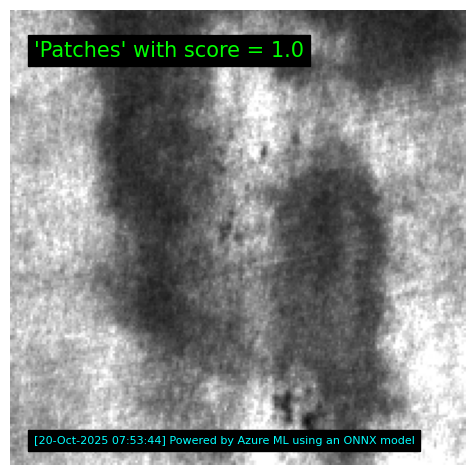

✅ Processed in 0.141 seconds using a local ONNX model


In [25]:
start = time.time()

onnx_image_classification(0)

print(f"✅ Processed in {(time.time() - start):.3f} seconds using a local ONNX model")

Image classification prediction result: 'Pitted' with score = 0.999765


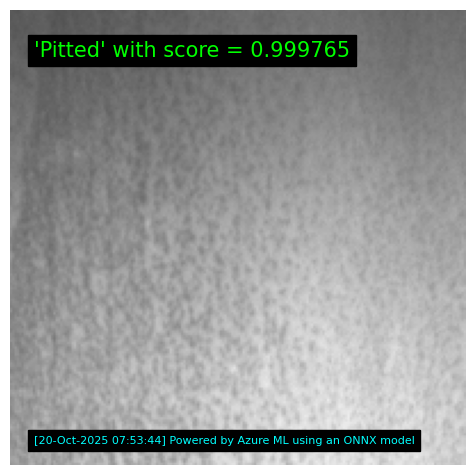

✅ Processed in 0.087 seconds using a local ONNX model


In [26]:
start = time.time()

onnx_image_classification(1)

print(f"✅ Processed in {(time.time() - start):.3f} seconds using a local ONNX model")

Image classification prediction result: 'Scratches' with score = 0.999992


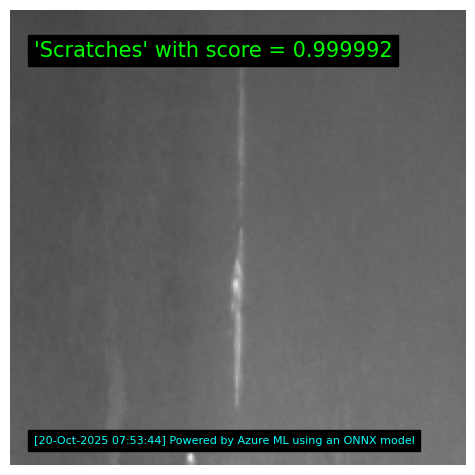

✅ Processed in 0.080 seconds using a local ONNX model


In [27]:
start = time.time()

onnx_image_classification(2)

print(f"✅ Processed in {(time.time() - start):.3f} seconds using a local ONNX model")

Image classification prediction result: 'Rolled' with score = 0.998829


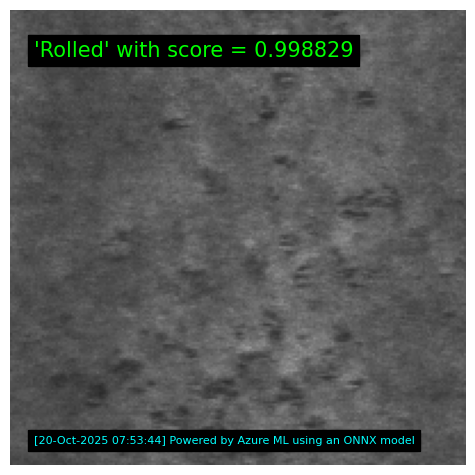

✅ Processed in 0.089 seconds using a local ONNX model


In [28]:
start = time.time()

onnx_image_classification(3)

print(f"✅ Processed in {(time.time() - start):.3f} seconds using a local ONNX model")

Image classification prediction result: 'Crazing' with score = 0.999672


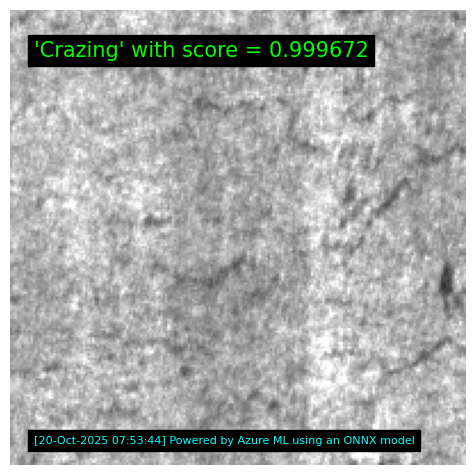

✅ Processed in 0.096 seconds using a local ONNX model


In [29]:
start = time.time()

onnx_image_classification(4)

print(f"✅ Processed in {(time.time() - start):.3f} seconds using a local ONNX model")